# Project Week 1: ActivityNet Video Data Preparation and Indexing

In this example we will use the ActivityNet dataset https://github.com/activitynet/ActivityNet. 

 - Select the 10 videos with more moments.
 - Download these videos onto your computer.
 - Extract the frames for every video.
 - Read the textual descriptions of each video.
 - Index the video data in OpenSearch.

 In this week, you will index the video data and make it searchable with OpenSearch. You should refer to the OpenSearch tutorial laboratory.

## Select videos
Download the `activity_net.v1-3.min.json` file containing the list of videos. The file is in the github repository of ActivityNet.
Parse this file and select the 10 videos with more moments.

In [94]:
import json
import os

from numpy.random import shuffle
from yt_dlp import YoutubeDL
import requests
import pickle as pk
import av
import pprint as pp
from opensearchpy import OpenSearch
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import numpy as np

FRAMES_DIR = "frames"
path = "downloads/"

host = 'localhost'
port = 9200

nova_host = 'api.novasearch.org'
nova_port = 443

user = 'user10'  # Add your user name here.
password = '2025.grupo10'  # Add your user password here. For testing only. Don't store credentials in code. 

local_user = 'admin'
local_pwd = '2025.Grupo10'  # Add your local password here. For testing only. Don't store credentials in code.
index_name = user

DOWNLOAD_DIR = "downloads"
FRAMES_DIR = "frames"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

In [63]:
def download_video(video_id, url):
    output_path = os.path.join(DOWNLOAD_DIR, f"{video_id}.mp4")
    if os.path.exists(output_path):
        print(f"Already downloaded: {video_id}")
        return

    ydl_opts = {
        'outtmpl': output_path,
        'format': 'best[ext=mp4]/best',
        'quiet': False,
        'noplaylist': True,
        'retries': 3
    }

    try:
        with YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
    except Exception as e:
        print(f"Failed to download {video_id}: {str(e)}")


def is_youtube_video_available(id):
    try:
        oembed_url = f"https://www.youtube.com/oembed?url=http://www.youtube.com/watch?v={id}&format=json"
        response = requests.get(oembed_url)
        if response.status_code != 200:
            return False

        url = f"https://www.youtube.com/watch?v={id}"

        response = requests.get(url)
        content = response.text

        # Check if the video is available by verifying the attribute "playabilityStatus"
        if 'playabilityStatus' in content:
            if '"status":"UNPLAYABLE"' in content:
                return False
            if '"status":"AGE_VERIFICATION_REQUIRED"' in content:
                return False
            if '"status":"LOGIN_REQUIRED"' in content:
                return False

        return True

    except Exception as e:
        print(f"Error checking video {id}: {str(e)}")
        return False


with open('../activity_net.v1-3.min.json', 'r') as json_data:
    moments_data = json.load(json_data)
    moments_data = moments_data['database']

with open('captions/train.json', 'r') as json_data:
    captions_data = json.load(json_data)

video_stats = []
for id, video_data in moments_data.items():
    num_moments = len(video_data.get('annotations', []))
    if "v_" + id not in captions_data:
        continue
    num_captions = len(captions_data["v_" + id]['sentences'])
    total = num_moments + num_captions
    video_stats.append({
        'id': id,
        'length': video_data.get('duration', ''),
        'resolution': video_data.get('resolution', ''),
        'num_moments': num_moments,
        'num_captions': num_captions,
        'url': video_data.get('url', ''),
        'total': total
    })

video_stats.sort(key=lambda x: x['total'], reverse=True)
top_videos = video_stats[: 10]
moments_data = {video['id']: moments_data[video['id']] for video in top_videos}

top_10_videos = []
for video in top_videos:
    if is_youtube_video_available(video['id']) and len(top_10_videos) < 10:
        top_10_videos.append(video)

for video in top_10_videos:
    #print(f"Video url: {video['url']}")
    download_video(video['id'], video['url'])

with open('top_10_videos.pkl', 'wb') as f:
    pk.dump(top_10_videos, f)

with open('moments_data.pkl', 'wb') as f:
    pk.dump(moments_data, f)

with open('captions_data.pkl', 'wb') as f:
    pk.dump(captions_data, f)

[youtube] Extracting URL: https://www.youtube.com/watch?v=tuhHQ-lHIs4
[youtube] tuhHQ-lHIs4: Downloading webpage
[youtube] tuhHQ-lHIs4: Downloading tv client config
[youtube] tuhHQ-lHIs4: Downloading tv player API JSON
[youtube] tuhHQ-lHIs4: Downloading ios player API JSON
[youtube] tuhHQ-lHIs4: Downloading m3u8 information
[info] tuhHQ-lHIs4: Downloading 1 format(s): 18
[download] Destination: downloads\tuhHQ-lHIs4.mp4
[download] 100% of    5.28MiB in 00:00:03 at 1.51MiB/s   
[youtube] Extracting URL: https://www.youtube.com/watch?v=o1WPnnvs00I
[youtube] o1WPnnvs00I: Downloading webpage
[youtube] o1WPnnvs00I: Downloading tv client config
[youtube] o1WPnnvs00I: Downloading tv player API JSON
[youtube] o1WPnnvs00I: Downloading ios player API JSON
[youtube] o1WPnnvs00I: Downloading m3u8 information
[info] o1WPnnvs00I: Downloading 1 format(s): 18
[download] Destination: downloads\o1WPnnvs00I.mp4
[download] 100% of   10.19MiB in 00:00:04 at 2.22MiB/s     
[youtube] Extracting URL: https://

## Video frame extraction

PyAV is a wrapper library providing you access to `ffmpeg`, a command-line video processing tool. In the example below, you will be able to extract frames from the a video shot.

In [64]:
import os
import av

# Create the frames directory if it doesn't exist
os.makedirs(FRAMES_DIR, exist_ok=True)

videos = os.listdir(path)

for video in videos:
    video_name, _ = os.path.splitext(video)
    video_frames_dir = os.path.join(FRAMES_DIR, video_name)

    # Only process the frames of the video if the directory does not exist
    if os.path.exists(video_frames_dir):
        print(f"Frames already extracted for {video_name}. Skipping...")
        continue

    os.makedirs(video_frames_dir, exist_ok=True)
    print(f"Processing video: {video_name}")
    video_path = os.path.join(path, video)

    with av.open(video_path) as container:
        stream = container.streams.video[0]
        time_base = stream.time_base

        saved_seconds = set()

        for frame in container.decode(stream):
            if frame.pts is None:
                continue  # Skip frames without PTS

            timestamp_seconds = int(frame.pts * time_base)

            # Save only one frame per 2 seconds
            if timestamp_seconds % 5 == 0 and timestamp_seconds not in saved_seconds:
                saved_seconds.add(timestamp_seconds)
                frame_path = os.path.join(video_frames_dir, f"{video_name}_{timestamp_seconds:04d}.jpg")
                frame.to_image().save(frame_path, quality=80)
                print(f"Saved frame at {timestamp_seconds} seconds for {video_name}")


Processing video: -fjUWhSM6Hc
Saved frame at 0 seconds for -fjUWhSM6Hc
Saved frame at 5 seconds for -fjUWhSM6Hc
Saved frame at 10 seconds for -fjUWhSM6Hc
Saved frame at 15 seconds for -fjUWhSM6Hc
Saved frame at 20 seconds for -fjUWhSM6Hc
Saved frame at 25 seconds for -fjUWhSM6Hc
Saved frame at 30 seconds for -fjUWhSM6Hc
Saved frame at 35 seconds for -fjUWhSM6Hc
Saved frame at 40 seconds for -fjUWhSM6Hc
Saved frame at 45 seconds for -fjUWhSM6Hc
Saved frame at 50 seconds for -fjUWhSM6Hc
Saved frame at 55 seconds for -fjUWhSM6Hc
Saved frame at 60 seconds for -fjUWhSM6Hc
Saved frame at 65 seconds for -fjUWhSM6Hc
Saved frame at 70 seconds for -fjUWhSM6Hc
Saved frame at 75 seconds for -fjUWhSM6Hc
Saved frame at 80 seconds for -fjUWhSM6Hc
Saved frame at 85 seconds for -fjUWhSM6Hc
Saved frame at 90 seconds for -fjUWhSM6Hc
Saved frame at 95 seconds for -fjUWhSM6Hc
Saved frame at 100 seconds for -fjUWhSM6Hc
Saved frame at 105 seconds for -fjUWhSM6Hc
Saved frame at 110 seconds for -fjUWhSM6Hc
Sav

## OpenSearch configuration

In [95]:
# Create the client with SSL/TLS enabled, but hostname verification disabled.
"""client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (local_user, local_pwd),
    use_ssl = True,
    #url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False
)"""

client = OpenSearch(
    hosts=[{'host': nova_host, 'port': nova_port}],
    http_compress=True,  # enables gzip compression for request bodies
    http_auth=(user, password),
    use_ssl=True,
    url_prefix='opensearch_v2',
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False
)

if client.indices.exists(index_name):

    resp = client.indices.open(index=index_name)
    print(resp)

    print('\n----------------------------------------------------------------------------------- INDEX SETTINGS')
    settings = client.indices.get_settings(index=index_name)
    pp.pprint(settings)

    print('\n----------------------------------------------------------------------------------- INDEX MAPPINGS')
    mappings = client.indices.get_mapping(index=index_name)
    pp.pprint(mappings)

    print('\n----------------------------------------------------------------------------------- INDEX #DOCs')
    print(client.count(index=index_name))
else:
    print("Index does not exist.")


{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'user10': {'settings': {'index': {'creation_date': '1747317763383',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '4',
                                   'provided_name': 'user10',
                                   'refresh_interval': '-1',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': 'a1LkVXhxTV-lR1wjVn2uGA',
                                   'version': {'created': '136387927'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'user10': {'mappings': {'dynamic': 'strict',
                         'properties': {'caption_embedding': {'dimension': 512,
                                          

### Index Deletion

In [38]:
#This line is here to prevent you from inadvertently deleting data.

if client.indices.exists(index=index_name):
    # Delete the index.
    response = client.indices.delete(
        index=index_name
    )
    print('\nDeleting index:')
    print(response)


Deleting index:
{'acknowledged': True}


### Index Creation

In [39]:
index_body = {
    "settings": {
        "index": {
            "number_of_replicas": 0,
            "number_of_shards": 4,
            "refresh_interval": "-1",
            "knn": "true"
        }
    },
    "mappings": {
        "dynamic": "strict",
        "properties": {
            "video_id": {"type": "keyword"},
            "video_url": {"type": "keyword"},
            "video_length": {"type": "keyword"},
            "video_resolution": {"type": "keyword"},
            "frame_path": {"type": "keyword"},
            "frame_name": {"type": "keyword"},
            "frame_moment_caption": {"type": "keyword"},
            "caption_text": {"type": "text"},
            "caption_start_time": {"type": "float"},
            "caption_end_time": {"type": "float"},
            "frame_timestamp": {"type": "integer"},
            "sentence_embedding": {
                "type": "knn_vector",
                "dimension": 768,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",
                    "engine": "lucene",
                    "parameters": {
                        "ef_construction": 256,
                        "m": 48
                    }
                }
            },
            "caption_embedding": {
                "type": "knn_vector",
                "dimension": 512,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",
                    "engine": "lucene",
                    "parameters": {
                        "ef_construction": 256,
                        "m": 48
                    }
                }
            },
            "image_base64": {
                "type": "text",
                "index": False,
                "doc_values": False
            },
            "frame_embedding": {
                "type": "knn_vector",
                "dimension": 512,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",
                    "engine": "lucene",
                    "parameters": {
                        "ef_construction": 256,
                        "m": 48
                    }
                }
            }
        }
    }
}

if client.indices.exists(index=index_name):
    print("Index already existed. You may force the new mappings.")
else:
    response = client.indices.create(index_name, body=index_body)
    print('\nCreating index:')
    print(response)


Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'user10'}


### Sentence Embedding

In [40]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F


#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode_text(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)

    return embeddings


def encode_text_clip(texts, model, processor):
    inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = F.normalize(text_features, p=2, dim=1)
    return text_features


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")

In [41]:
from ollama import Client

client = Client(
    host='https://twiz.novasearch.org/ollama',
    headers={'x-some-header': 'some-value'}
)

model_multimodal_llama = 'llava-phi3:latest'
img_path = "images/park.jpg"


def generate_llama_caption(img):
    response = client.chat(model=model_multimodal_llama, messages=[
        {
            'role': 'user',
            'content': 'Describe what you see in this image in one phrase with just 3 to 4 words. Make the phrase the shortest possible',
            'images': [img]
        }
    ])
    #isto gera várias captions, só queremos uma. senão isto demora imensoooo
    return response.message.content.split('*')[0].strip()

#print(generate_llama_caption(img_path))

### Process the videos and captions

In [42]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModel
import base64
import io
import os
import pickle as pk
import torch.nn.functional as F

# Load the larger CLIP model for 768-dimensional embeddings
model_image = AutoModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=torch.float32,
                                        attn_implementation="sdpa")
processor_image = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

video_data = []
top_10_videos = pk.load(open('top_10_videos.pkl', 'rb'))
moments_data = pk.load(open('moments_data.pkl', 'rb'))
captions_data = pk.load(open('captions_data.pkl', 'rb'))

print(f"Number of videos: {len(top_10_videos)}")

video_frame_docs = []

for video in top_10_videos:
    video_id = video['id']
    video_url = video['url']
    video_length = video['length']
    video_resolution = video['resolution']
    video_timestamps = captions_data["v_" + video_id]['timestamps']
    video_captions = captions_data["v_" + video_id]['sentences']
    video_frames_path = FRAMES_DIR + "/" + video_id
    video_moments = moments_data[video_id]['annotations']

    sentence_embeddings = encode_text(video_captions)
    frames = sorted(os.listdir(video_frames_path))

    frame_moment_caption = ""

    count = 0

    for frame_name in frames:
        frame_timestamp = int(frame_name.split("_")[-1].split(".")[0])
        frame_path = os.path.join(video_frames_path, frame_name)
        frame_path = frame_path.replace("\\", "/")
        for video_moment in video_moments:
            start_time = video_moment['segment'][0]
            end_time = video_moment['segment'][1]
            if start_time <= frame_timestamp <= end_time:
                frame_moment_caption = video_moment['label']
            else:
                count += 1
                image = Image.open(frame_path).convert("RGB")
                buffered = io.BytesIO()
                image.save(buffered, format="JPEG", quality=85)
                img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
                frame_moment_caption = generate_llama_caption(img_base64)
                #frame_moment_caption = ""

        closest_caption_idx = 0
        min_diff = float('inf')

        # TODO: aqui em vez de irmos buscar a caption mais perto, para as frames sem caption pedir a description ao Llama
        for i, timestamp_range in enumerate(video_timestamps):
            start_time, end_time = timestamp_range
            if start_time <= frame_timestamp <= end_time:
                closest_caption_idx = i
                min_diff = 0
                break
            else:
                diff = min(abs(start_time - frame_timestamp), abs(end_time - frame_timestamp))
                if diff < min_diff:
                    min_diff = diff
                    closest_caption_idx = i

        caption = video_captions[closest_caption_idx]
        caption_timestamp_range = video_timestamps[closest_caption_idx]

        caption_start_time = caption_timestamp_range[0]
        caption_end_time = caption_timestamp_range[1]

        # Caption
        sentence_embedding = sentence_embeddings[closest_caption_idx].numpy().tolist()

        image = Image.open(frame_path).convert("RGB")
        buffered = io.BytesIO()
        image.save(buffered, format="JPEG", quality=85)
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

        # Do the caption embedding using CLIP - Visual Caption
        inputs = processor_image(text=caption, return_tensors="pt", padding=True)
        with torch.no_grad():
            query_emb = model_image.get_text_features(**inputs)
            query_emb = F.normalize(query_emb, p=2, dim=1)
        caption_embedding = query_emb.squeeze(0).numpy().tolist()

        # Do the image embedding using CLIP - Frame
        inputs = processor_image(images=image, return_tensors="pt", padding=True)
        with torch.no_grad():
            image_emb = model_image.get_image_features(**inputs)
            image_emb = F.normalize(image_emb, p=2, dim=1)

        frame_embedding = image_emb.squeeze(0).numpy().tolist()

        doc = {
            "video_id": video_id,
            "video_url": video_url,
            "video_length": video_length,
            "video_resolution": video_resolution,
            "frame_path": frame_path,
            "frame_name": frame_name,
            "frame_timestamp": frame_timestamp,
            "frame_moment_caption": frame_moment_caption,
            "caption_text": caption,
            "caption_start_time": caption_start_time,
            "caption_end_time": caption_end_time,
            "frame_embedding": frame_embedding,
            "caption_embedding": caption_embedding,
            "sentence_embedding": sentence_embedding,
            "image_base64": img_base64  #TODO: depois tirar as imagens do index
        }
        video_frame_docs.append(doc)
    print(count)

with open('video_frame_docs.pkl', 'wb') as f:
    pk.dump(video_frame_docs, f)


Number of videos: 10
31
1026
695
55
763
663
766
46
907
5


### Index the video data

In [47]:
video_frames = pk.load(open('video_frame_docs.pkl', 'rb'))

for doc_frames in video_frames:
    try:
        # Make sure frame_embedding is not None
        if doc_frames.get('frame_embedding') is None:
            print(f"Skipping document with missing frame_embedding: {doc_frames.get('frame_name', 'unknown')}")
            continue

        resp = client.index(index=index_name, body=doc_frames)
        #print(resp['result'])
    except Exception as e:
        print(f"Error indexing document: {e}")
        # Optionally print the problematic document for debugging
        print(f"Problematic document: {doc_frames}")

client.indices.refresh(index=index_name)
count = client.count(index=index_name)
print("Document count:", count['count'])


Document count: 395


# 2.4

## Queries

### Input - Text
### Output - Image


In [25]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModel
import base64
import io

model_image = AutoModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=torch.float32,
                                        attn_implementation="sdpa")
processor_image = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")


# Compute query CLIP embbeding to retrieve the most similar frames
def compute_query_embedding(query):
    inputs = processor_image(text=query, return_tensors="pt", padding=True)
    with torch.no_grad():
        query_emb = model_image.get_text_features(**inputs)
        query_emb = F.normalize(query_emb, p=2, dim=-1)
    return query_emb


query = "some people swimming"
query_embedding = compute_query_embedding(query)
query_embedding = query_embedding.squeeze(0).numpy().tolist()

# Perform the search
search_body = {
    "size": 2,
    "query": {
        "knn": {
            "frame_embedding": {
                "vector": query_embedding,
                "k": 2
            }
        }
    }
}
response = client.search(index=index_name, body=search_body)
print("Search results:")
for hit in response['hits']['hits']:
    print(f"Frame: {hit['_source']['frame_name']}, Score: {hit['_score']}")
    # Optionally, you can also display the image using base64
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    #print(image.)
    image.show()

Search results:
Frame: DLJqhYP-C0k_0120.jpg, Score: 0.6240411
Frame: VEDRmPt_-Ms_0085.jpg, Score: 0.6215566


### Input - Image
### Output - Image


In [26]:
# Compute the image query embedding

def compute_image_query_embedding(image_path):
    image = Image.open(image_path)
    image = image.convert("RGB")

    buffered = io.BytesIO()
    image.save(buffered, format="JPEG", quality=85)

    inputs = processor_image(images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        image_emb = model_image.get_image_features(**inputs)
        image_emb = F.normalize(image_emb, p=2, dim=1)

    return image_emb


image_path = "images/kitchen.jpg"  # Replace with your image path
query_embedding = compute_image_query_embedding(image_path)
query_embedding = query_embedding.squeeze(0).numpy().tolist()

search_body = {
    "size": 3,
    "query": {
        "knn": {
            "frame_embedding": {
                "vector": query_embedding,
                "k": 3
            }
        }
    }
}
response = client.search(index=index_name, body=search_body)
print("Search results:")
for hit in response['hits']['hits']:
    print(f"Frame: {hit['_source']['frame_name']}, Score: {hit['_score']}")
    # Optionally, you can also display the image using base64
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    image.show()


Search results:
Frame: -rKS00dzFxQ_0050.jpg, Score: 0.79315996
Frame: -rKS00dzFxQ_0045.jpg, Score: 0.78803813
Frame: -rKS00dzFxQ_0160.jpg, Score: 0.78560746


### Input: Text + Image
### Output: Image

In [27]:
## Compute the caption embedding with image embedding using CLIP
query = "blue"
image = "images/park.jpg"

image_emb = compute_image_query_embedding(image)
query_emb = compute_query_embedding(query)

# Sum the two embeddings and normalize
combined_embedding = (image_emb + query_emb) / 2
combined_embedding = combined_embedding.squeeze(0).numpy().tolist()

search_body = {
    "size": 3,
    "query": {
        "knn": {
            "frame_embedding": {
                "vector": combined_embedding,
                "k": 3
            }
        }
    }
}
response = client.search(index=index_name, body=search_body)
print("Search results:")
for hit in response['hits']['hits']:
    print(f"Frame: {hit['_source']['frame_name']}, Score: {hit['_score']}")
    # Optionally, you can also display the image using base64
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    image.show()


Search results:
Frame: -fjUWhSM6Hc_0000.jpg, Score: 0.7416458
Frame: DLJqhYP-C0k_0000.jpg, Score: 0.7410028
Frame: VEDRmPt_-Ms_0000.jpg, Score: 0.7272529


### Input: Image + Image
### Output: Image

In [16]:
## Compute the caption embedding with image embedding using CLIP
image = "images/kids_school.jpg"
image2 = "images/sports.jpg"

image_emb = compute_image_query_embedding(image)
image2_emb = compute_image_query_embedding(image2)

combined_embedding = (image_emb + image2_emb) / 2
combined_embedding = combined_embedding.squeeze(0).numpy().tolist()

search_body = {
    "size": 2,
    "query": {
        "knn": {
            "frame_embedding": {
                "vector": combined_embedding,
                "k": 3
            }
        }
    }
}
response = client.search(index=index_name, body=search_body)
print("Search results:")
for hit in response['hits']['hits']:
    print(f"Frame: {hit['_source']['frame_name']}, Score: {hit['_score']}")
    #caption_text = hit['_source']['caption_text']
    #print(f"Caption: {caption_text}")
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    image.show()


Search results:
Frame: cGNkR-JvaJs_0156.jpg, Score: 0.8551999
Frame: lxMSX0Y0b8I_0010.jpg, Score: 0.85511196


### 3.3.1

### For each moment/caption, compute the CLIP score for each frame every 2 seconds. Using one single graph, plot the CLIP score curve for each caption/moment for the entire duration of the video.

C:\Users\jgcri\AppData\Local\Temp\ipykernel_17440\154538305.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(captions_text_arr))


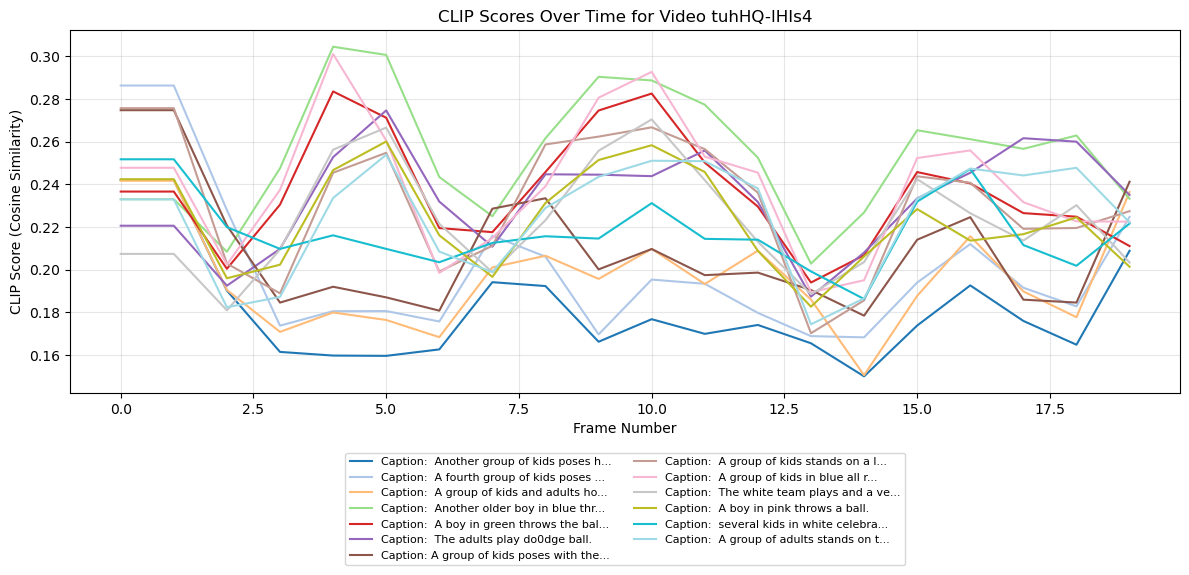


Peak moments for each caption:
Caption: ' Another group of kids poses holding up peace sign...' - Peak at frame 19 with score 0.2564
Caption: ' A fourth group of kids poses with their mouths op...' - Peak at frame 1 with score 0.2941
Caption: ' A group of kids and adults hold up trophy's and w...' - Peak at frame 19 with score 0.2909
Caption: ' Another older boy in blue throws a dodge ball....' - Peak at frame 9 with score 0.3146
Caption: ' A boy in green throws the ball and the blue team ...' - Peak at frame 9 with score 0.3142
Caption: ' The adults play do0dge ball....' - Peak at frame 5 with score 0.2851
Caption: 'A group of kids poses with the arms in the air....' - Peak at frame 7 with score 0.2836
Caption: ' A group of kids stands on a line in a gym....' - Peak at frame 9 with score 0.2913
Caption: ' A group of kids in blue all run toward the center...' - Peak at frame 9 with score 0.3525
Caption: ' The white team plays and a very young player thro...' - Peak at frame 9 with sco

In [51]:
# Search for all the different captions of this video "0z7qHOca3D4"
video_id = "tuhHQ-lHIs4"
search_body = {
    "size": 500,
    "query": {
        "match": {
            "video_id": video_id
        }
    }
}
response = client.search(index=index_name, body=search_body)
captions_text_arr = []
for hit in response['hits']['hits']:
    caption_text = hit['_source']['caption_text']
    if caption_text not in captions_text_arr:
        captions_text_arr.append(caption_text)

captions_embeddings_arr = []
for hit in response['hits']['hits']:
    caption_embedding = hit['_source']['caption_embedding']
    if caption_embedding not in captions_embeddings_arr:
        captions_embeddings_arr.append(caption_embedding)

frame_images = []
for hit in response['hits']['hits']:
    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    if image not in frame_images:
        frame_images.append(image)

frame_embeddings = []
for hit in response['hits']['hits']:
    frame_embedding = hit['_source']['frame_embedding']
    if frame_embedding not in frame_embeddings:
        frame_embeddings.append(frame_embedding)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.colors as mcolors


def compute_clip_scores(caption_embedding, frame_embeddings):
    # Reshape caption embedding for proper broadcasting
    caption_embedding = np.array(caption_embedding).reshape(1, -1)
    frame_embeddings_array = np.array(frame_embeddings)

    # Compute cosine similarity between caption and all frames
    similarities = cosine_similarity(caption_embedding, frame_embeddings_array)[0]
    return similarities


# Create figure and axis
plt.figure(figsize=(12, 6))

# Set up a colormap for different captions
colors = list(mcolors.TABLEAU_COLORS)
if len(captions_text_arr) > len(colors):
    # If we have more captions than colors, use a continuous colormap
    cmap = plt.cm.get_cmap('tab20', len(captions_text_arr))
    colors = [cmap(i) for i in range(len(captions_text_arr))]

# Time points (assuming frames are evenly spaced)
# If you have actual timestamps, replace this with those values
time_points = np.arange(len(frame_embeddings))

# For each caption, compute CLIP scores with all frames and plot
for i, (caption_text, caption_embedding) in enumerate(zip(captions_text_arr, captions_embeddings_arr)):
    # Compute CLIP scores
    clip_scores = compute_clip_scores(caption_embedding, frame_embeddings)

    # Smooth by averaging with the previous score
    smoothed_scores = np.convolve(clip_scores, np.ones(2) / 2, mode='valid')

    # Pad the beginning to match original length
    smoothed_scores = np.insert(smoothed_scores, 0, smoothed_scores[0])

    # Plot the scores
    plt.plot(time_points, smoothed_scores, color=colors[i % len(colors)],
             label=f"Caption: {caption_text[:30]}..." if len(caption_text) > 30 else f"Caption: {caption_text}")

# Add labels and title
plt.xlabel('Frame Number')
plt.ylabel('CLIP Score (Cosine Similarity)')
plt.title(f'CLIP Scores Over Time for Video {video_id}')

# Add grid
plt.grid(True, alpha=0.3)

# Add legend (with smaller font size if many captions)
font_size = 10 if len(captions_text_arr) <= 10 else 8
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=2, fontsize=font_size)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Additional analysis: Find peak moments for each caption
print("\nPeak moments for each caption:")
for i, caption_text in enumerate(captions_text_arr):
    clip_scores = compute_clip_scores(captions_embeddings_arr[i], frame_embeddings)
    peak_frame = np.argmax(clip_scores)
    peak_score = clip_scores[peak_frame]
    print(f"Caption: '{caption_text[:50]}...' - Peak at frame {peak_frame} with score {peak_score:.4f}")



In [30]:
%pip install einops ftfy captum regex

import CLIP.clip as clip
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import visualization
import torch


Note: you may need to restart the kernel to use updated packages.


In [53]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer = -1  #@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text = -1  #@param {type:"number"}


def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    #
    # print(logits_per_image)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
        # calculate index of last layer
        start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
        # calculate index of last layer
        start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
            continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance, logits_per_text, logits_per_image

In [52]:
import matplotlib.pyplot as plt


def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        cmap = plt.get_cmap('jet')
        rgba_img = cmap(mask)
        heatmap = np.delete(rgba_img, 3, 2)
        cam = np.float32(heatmap) / np.max(heatmap)
        cam = (cam + img) / 2
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    axs[1].imshow(vis);
    axs[1].axis('off');


from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

_tokenizer = _Tokenizer()


def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    # print(text_scores)
    text_tokens = _tokenizer.encode(text)
    text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]
    visualization.visualize_text(vis_data_records)

In [54]:
clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}


class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a set of chairs


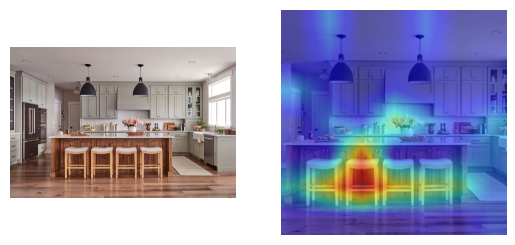

In [55]:
img_path = "images/kitchen.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a set of chairs"]
text = clip.tokenize(texts).to(device)

R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show()

### For a maximum of 10 frames, equally spaced by 2 seconds, repeat the above process for the interpretable visual maps. Given an initial timestamp, plot the visual attention maps for all moments/captions. For example, if your video has 3 moments, then your graph should have 3 rows and 10 columns.

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an introduction graphic is seen with title .


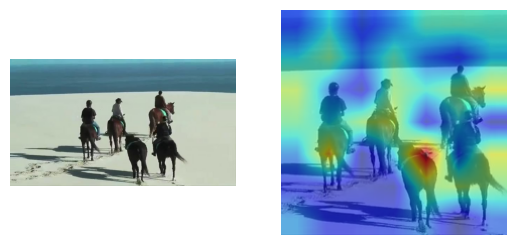

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a large empty beach is seen seen from the shore .


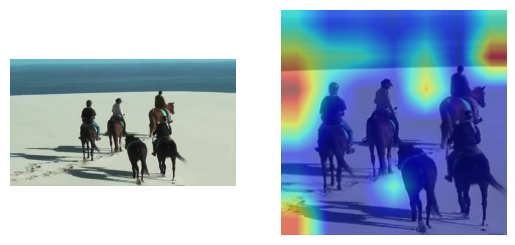

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a bird is seen walking along the shoreline .


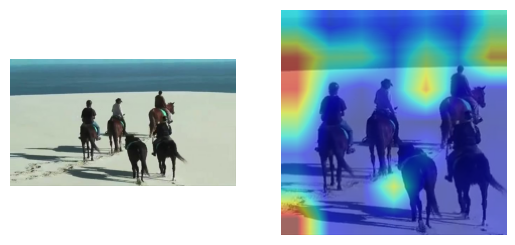

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,the group rides up along the bluffs .


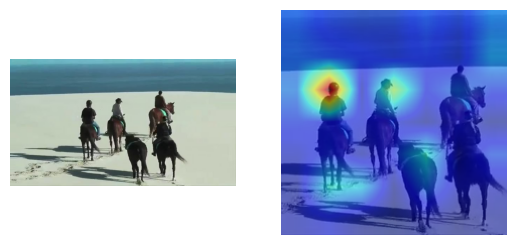

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a female rider rides near the waters edge .


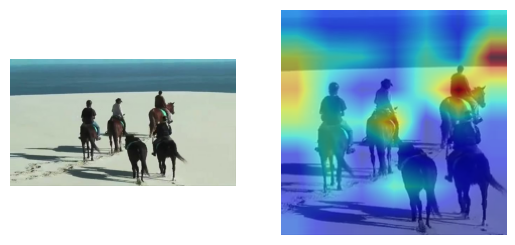

In [38]:
start_point = 12
nrframes = 1

ten_frames = []
for i in range(start_point, start_point + nrframes):
    ten_frames.append(frame_images[i])

texts = captions_text_arr  # 12 captions * 10 frames = 120 images

texts = texts[:5]  # Limit to 5 captions for the example

for idx, frame_img in enumerate(ten_frames):
    img = preprocess(frame_img).unsqueeze(0).to(device)
    text = clip.tokenize(texts).to(device)

    R_text, R_image, logits_per_text, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
    batch_size = text.shape[0]
    for i in range(batch_size):
        show_heatmap_on_text(texts[i], text[i], R_text[i])
        show_image_relevance(R_image[i], img, orig_image=frame_img)
        plt.show()

### Using Llama frame's descriptions as captions

## 3.3.2 - Language-Vision contrastive moments
In this section you will do a complete pairwise comparison across all moments in each video.
Both visualizations must have an equal number of rows and columns corresponding to the
number of moments:
• For every video moment, select the keyframe and compare it to all other captions,
using the CLIP similarity score. Plot these results as a contrastive matrix, i.e., rows
are frames and columns are captions.
• Repeat the above process with the interpretable visual maps. Every (x,y) position in
the graph should show the heatmap between caption of moment x and frame of
moment y.

In [76]:
video = top_10_videos[1]

video_id = 'o1WPnnvs00I'
video_url = video['url']
video_length = video['length']
video_resolution = video['resolution']
video_timestamps = captions_data["v_" + video_id]['timestamps']
video_captions = captions_data["v_" + video_id]['sentences']
video_frames_path = FRAMES_DIR + "/" + video_id
video_moments = moments_data[video_id]['annotations']

In [72]:
import os
import pickle as pk


def find_all_moment_keyframes(video_id):
    moments_data = pk.load(open('moments_data.pkl', 'rb'))
    moments = moments_data[video_id]['annotations']

    # Load frame list and timestamps once
    frame_dir = os.path.join(FRAMES_DIR, video_id)
    frames = sorted(os.listdir(frame_dir))
    frame_timestamps = []
    for frame in frames:
        try:
            ts = int(frame.split("_")[-1].split(".")[0])
            frame_timestamps.append((frame, ts))
        except ValueError:
            continue

    result = []

    for moment in moments:
        start_time = moment['segment'][0]
        label = moment['label']

        closest_frame, closest_ts = min(
            frame_timestamps,
            key=lambda x: abs(x[1] - start_time)
        )

        result.append({
            'label': label,
            'frame': closest_frame,
            'timestamp': closest_ts
        })

    return video_id, result


video_id, keyframes = find_all_moment_keyframes('o1WPnnvs00I')

for kf in keyframes:
    print(f"Label: {kf['label']}, Frame: {kf['frame']}, Timestamp: {kf['timestamp']}")


Label: Playing flauta, Frame: o1WPnnvs00I_0005.jpg, Timestamp: 5
Label: Playing flauta, Frame: o1WPnnvs00I_0020.jpg, Timestamp: 20
Label: Playing flauta, Frame: o1WPnnvs00I_0030.jpg, Timestamp: 30
Label: Playing flauta, Frame: o1WPnnvs00I_0040.jpg, Timestamp: 40
Label: Playing flauta, Frame: o1WPnnvs00I_0045.jpg, Timestamp: 45
Label: Playing flauta, Frame: o1WPnnvs00I_0060.jpg, Timestamp: 60
Label: Playing flauta, Frame: o1WPnnvs00I_0070.jpg, Timestamp: 70
Label: Playing flauta, Frame: o1WPnnvs00I_0100.jpg, Timestamp: 100
Label: Playing flauta, Frame: o1WPnnvs00I_0100.jpg, Timestamp: 100
Label: Playing flauta, Frame: o1WPnnvs00I_0110.jpg, Timestamp: 110
Label: Playing flauta, Frame: o1WPnnvs00I_0115.jpg, Timestamp: 115
Label: Playing flauta, Frame: o1WPnnvs00I_0125.jpg, Timestamp: 125
Label: Playing flauta, Frame: o1WPnnvs00I_0130.jpg, Timestamp: 130
Label: Playing flauta, Frame: o1WPnnvs00I_0145.jpg, Timestamp: 145
Label: Playing flauta, Frame: o1WPnnvs00I_0160.jpg, Timestamp: 160
Lab

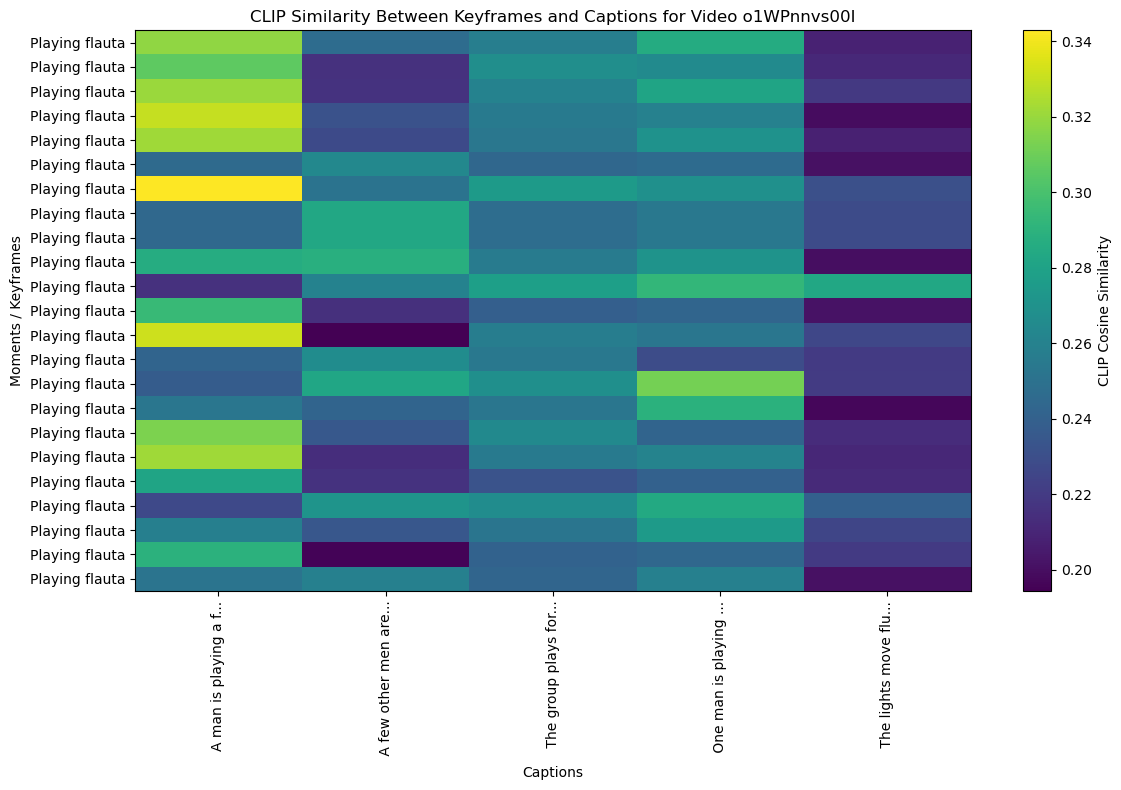

In [84]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Step 1: Build a map from frame filename to its index in the embeddings
frame_files = sorted(os.listdir(os.path.join(FRAMES_DIR, video_id)))
frame_index_map = {
    f: i for i, f in enumerate(frame_files)
}

# Step 2: Extract embeddings for each keyframe in order
keyframe_embeddings = []
keyframe_labels = []
for kf in keyframes:
    frame_file = kf['frame']
    if frame_file in frame_index_map:
        idx = frame_index_map[frame_file]
        keyframe_embeddings.append(frame_embeddings[idx])
        keyframe_labels.append(kf['label'])

keyframe_embeddings = np.array(keyframe_embeddings)
caption_embeddings = np.array(captions_embeddings_arr)

# Step 3: Compute similarity matrix (rows=keyframes, cols=captions)
similarity_matrix = cosine_similarity(keyframe_embeddings, caption_embeddings)

# Step 4: Plot heatmap
plt.figure(figsize=(12, 8))
plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='CLIP Cosine Similarity')
plt.xticks(ticks=np.arange(len(captions_text_arr)), labels=[t[:20] + '...' if len(t) > 20 else t for t in captions_text_arr], rotation=90)
plt.yticks(ticks=np.arange(len(keyframe_labels)), labels=keyframe_labels)
plt.title(f'CLIP Similarity Between Keyframes and Captions for Video {video_id}')
plt.xlabel('Captions')
plt.ylabel('Moments / Keyframes')
plt.tight_layout()
plt.show()


In [87]:
import os
import pickle as pk
import io
import base64
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.colors as mcolors
from PIL import Image

# ========== CONFIG ==========
video_id = "o1WPnnvs00I"

# ========== HELPER ==========
def compute_clip_scores(caption_embedding, frame_embeddings):
    caption_embedding = np.array(caption_embedding).reshape(1, -1)
    frame_embeddings_array = np.array(frame_embeddings)
    similarities = cosine_similarity(caption_embedding, frame_embeddings_array)[0]
    return similarities

def find_all_moment_keyframes(video_id):
    moments_data = pk.load(open('moments_data.pkl', 'rb'))
    moments = moments_data[video_id]['annotations']
    frame_dir = os.path.join(FRAMES_DIR, video_id)
    frames = sorted(os.listdir(frame_dir))
    frame_timestamps = []
    for frame in frames:
        try:
            ts = int(frame.split("_")[-1].split(".")[0])
            frame_timestamps.append((frame, ts))
        except ValueError:
            continue
    result = []
    for moment in moments:
        start_time = moment['segment'][0]
        label = moment['label']
        closest_frame, closest_ts = min(
            frame_timestamps, key=lambda x: abs(x[1] - start_time)
        )
        result.append({
            'label': label,
            'frame': closest_frame,
            'timestamp': closest_ts
        })
    return video_id, result

# ========== LOAD DATA FROM ELASTIC ==========
search_body = {
    "size": 500,
    "query": {
        "match": {
            "video_id": video_id
        }
    }
}
response = client.search(index=index_name, body=search_body)

captions_text_arr = []
captions_embeddings_arr = []
frame_images = []
frame_embeddings = []

for hit in response['hits']['hits']:
    caption_text = hit['_source']['caption_text']
    if caption_text not in captions_text_arr:
        captions_text_arr.append(caption_text)
        captions_embeddings_arr.append(hit['_source']['caption_embedding'])

    frame_embedding = hit['_source']['frame_embedding']
    if frame_embedding not in frame_embeddings:
        frame_embeddings.append(frame_embedding)

    img_data = hit['_source']['image_base64']
    image = Image.open(io.BytesIO(base64.b64decode(img_data)))
    if image not in frame_images:
        frame_images.append(image)

# ========== GET FIRST MOMENT FRAME ==========
video_id, keyframes = find_all_moment_keyframes(video_id)
first_keyframe = keyframes[0]  # First moment

frame_dir = os.path.join(FRAMES_DIR, video_id)
frame_files = sorted(os.listdir(frame_dir))
frame_index_map = {fname: i for i, fname in enumerate(frame_files)}

first_keyframe_filename = first_keyframe['frame']
first_keyframe_index = frame_index_map.get(first_keyframe_filename, None)

# ========== PLOT ==========
plt.figure(figsize=(12, 6))
colors = list(mcolors.TABLEAU_COLORS)
if len(captions_text_arr) > len(colors):
    cmap = plt.cm.get_cmap('tab20', len(captions_text_arr))
    colors = [cmap(i) for i in range(len(captions_text_arr))]

time_points = np.arange(len(frame_embeddings))

for i, (caption_text, caption_embedding) in enumerate(zip(captions_text_arr, captions_embeddings_arr)):
    clip_scores = compute_clip_scores(caption_embedding, frame_embeddings)
    smoothed_scores = np.convolve(clip_scores, np.ones(2) / 2, mode='valid')
    smoothed_scores = np.insert(smoothed_scores, 0, smoothed_scores[0])

    plt.plot(time_points, smoothed_scores, color=colors[i % len(colors)],
             label=f"Caption: {caption_text[:30]}..." if len(caption_text) > 30 else f"Caption: {caption_text}")

# Highlight the first moment keyframe
if first_keyframe_index is not None:
    plt.axvline(x=first_keyframe_index, color='red', linestyle='--', linewidth=2,
                label='First Moment Keyframe')

plt.xlabel('Frame Number')
plt.ylabel('CLIP Score (Cosine Similarity)')
plt.title(f'CLIP Scores Over Time for Video {video_id}')
plt.grid(True, alpha=0.3)

font_size = 10 if len(captions_text_arr) <= 10 else 8
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
           ncol=2, fontsize=font_size)

plt.tight_layout()
plt.show()

# ========== ANALYSIS ==========
print("\nPeak moments for each caption:")
for i, caption_text in enumerate(captions_text_arr):
    clip_scores = compute_clip_scores(captions_embeddings_arr[i], frame_embeddings)
    peak_frame = np.argmax(clip_scores)
    peak_score = clip_scores[peak_frame]
    print(f"Caption: '{caption_text[:50]}...' - Peak at frame {peak_frame} with score {peak_score:.4f}")


AuthorizationException: AuthorizationException(403, 'security_exception', 'no permissions for [indices:data/read/search] and User [name=user10, backend_roles=[own_index], requestedTenant=null]')

## 3.3.2 - Language-Vision contrastive moments
In this section you will do a complete pairwise comparison across all moments in each video.
Both visualizations must have an equal number of rows and columns corresponding to the
number of moments:
• For every video moment, select the keyframe and compare it to all other captions,
using the CLIP similarity score. Plot these results as a contrastive matrix, i.e., rows
are frames and columns are captions.
• Repeat the above process with the interpretable visual maps. Every (x,y) position in
the graph should show the heatmap between caption of moment x and frame of
moment y.

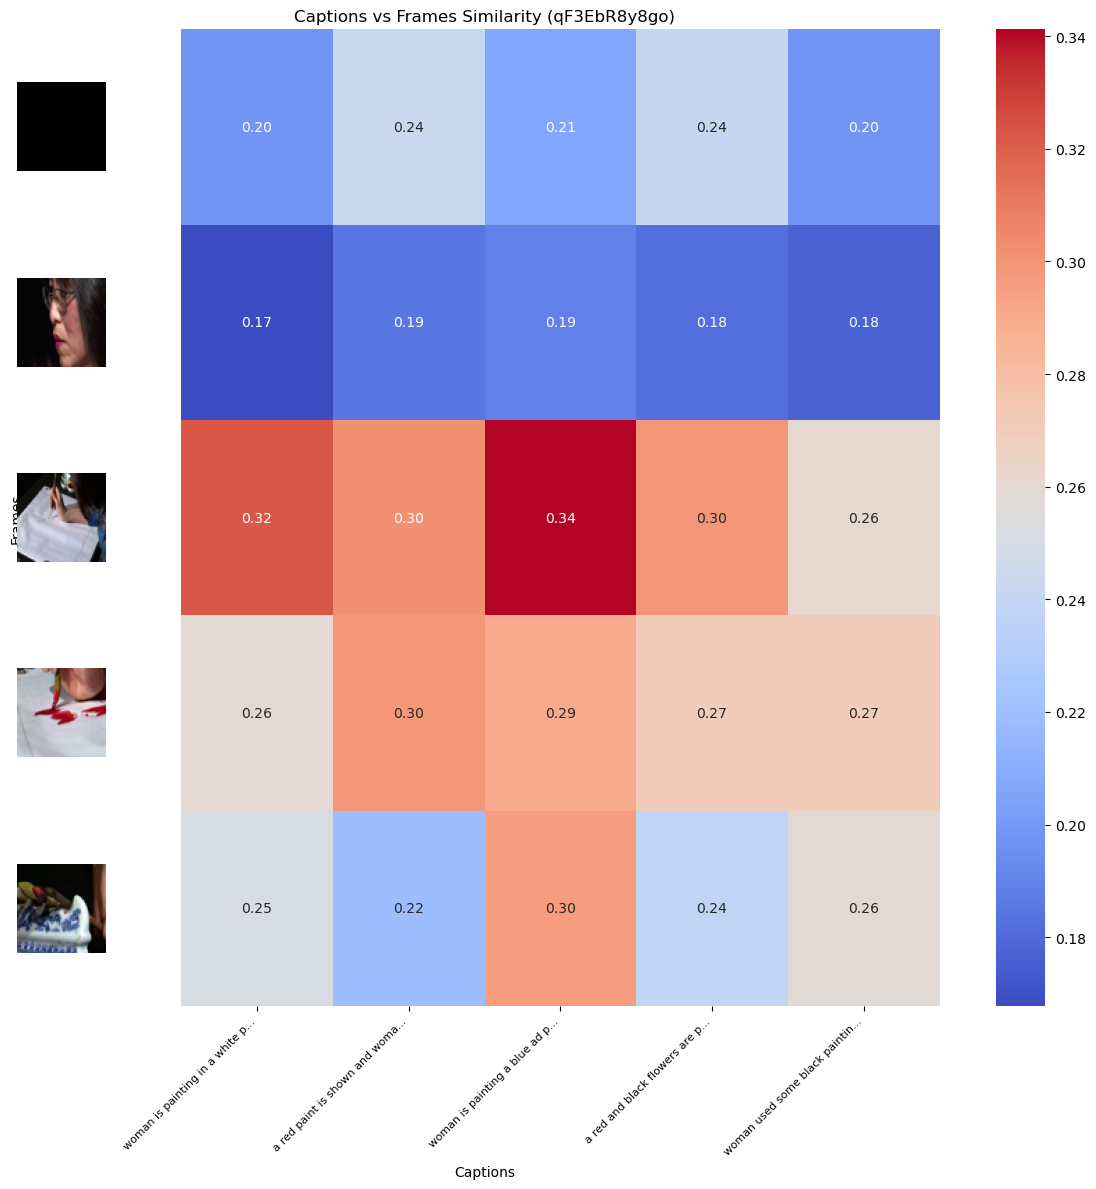

In [152]:
import os
import io
import base64
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import ImageOps


video_id = 'qF3EbR8y8go'
video_frames_path = os.path.join(FRAMES_DIR, video_id)
frames = sorted(os.listdir(video_frames_path))

video_captions = captions_data["v_" + video_id]['sentences']
video_captions_timestamps = captions_data["v_" + video_id]['timestamps']

caption_to_timestamp = {
    caption: video_captions_timestamps[i]
    for i, caption in enumerate(video_captions)
}

caption_to_frame = {}
caption_to_frame_name = {}

for caption, ts_list in caption_to_timestamp.items():
    if isinstance(ts_list[0], (int, float)):
        ts_list = [ts_list]

    for start_time, end_time in ts_list:
        for frame_name in frames:
            try:
                frame_timestamp = int(frame_name.split("_")[-1].split(".")[0])
                if start_time <= frame_timestamp <= end_time:
                    caption_to_frame[caption] = frame_timestamp
                    caption_to_frame_name[caption] = frame_name
                    break
            except:
                continue
        if caption in caption_to_frame:
            break

search_body = {
    "size": 500,
    "query": {
        "match": {
            "video_id": video_id
        }
    }
}
response = client.search(index=index_name, body=search_body)

frame_embedding_map = {}
caption_embedding_map = {}
frame_image_map = {}

for hit in response['hits']['hits']:
    frame_name = hit['_source']['frame_name']
    caption_text = hit['_source']['caption_text']
    frame_embedding = hit['_source']['frame_embedding']
    caption_embedding = hit['_source']['caption_embedding']
    img_data = hit['_source']['image_base64']

    if frame_name in caption_to_frame_name.values():
        frame_embedding_map[frame_name] = frame_embedding
        image = Image.open(io.BytesIO(base64.b64decode(img_data))).resize((64, 64))
        frame_image_map[frame_name] = image

    if caption_text in caption_to_frame:
        caption_embedding_map[caption_text] = caption_embedding


frame_names = list(caption_to_frame_name.values())
captions = list(caption_to_frame_name.keys())

frame_embeddings = [frame_embedding_map[fn] for fn in frame_names]
caption_embeddings = [caption_embedding_map[cap] for cap in captions]

similarity_matrix = cosine_similarity(np.array(frame_embeddings), np.array(caption_embeddings))

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    similarity_matrix,
    xticklabels=[c[:30] + '...' if len(c) > 30 else c for c in captions],
    yticklabels=False,
    cmap="coolwarm", annot=True, fmt=".2f", ax=ax
)

ax.set_xlim(-1, len(captions))  # Extend X-axis so images can be shown

for i, frame_name in enumerate(frame_names):
    curr_img_path = os.path.join(video_frames_path, frame_name)

    # Open and convert to RGB to prevent inversion
    image = Image.open(curr_img_path).convert("RGB")

    # Resize manually with PIL before converting to array
    image = image.resize((64, 64))  # Or tweak this size

    # Convert to numpy array and create annotation box with zoom
    imagebox = OffsetImage(np.array(image))
    ab = AnnotationBbox(imagebox, (-0.5, i + 0.5), frameon=False, box_alignment=(1, 0.5))
    ax.add_artist(ab)



ax.set_title(f"Captions vs Frames Similarity ({video_id})")
ax.set_xlabel("Captions")
ax.set_ylabel("Frames")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()
